## VAE and InfoVAE on a simplistic Gaussian Mixture problem

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sts
import torch
import torch.nn as nn
import torch.utils.data as tdata

import vaes_ptorch.args as args
import vaes_ptorch.models as models
import vaes_ptorch.train_vae as train_vae
import vaes_ptorch.vae as vae_nn

In [2]:
data = np.array([[1.0], [-1.0]])

(array([1., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

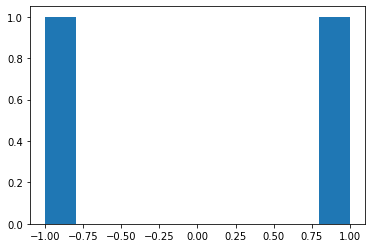

In [3]:
plt.hist(data.flatten())

In [11]:
data_dim = 1
latent_dim = 1

h_size = 128
h_layers = 3

lr = 1e-3
batch_size = 2
num_epochs = 1000

print_every = 100

# info_vae = False
# end_scale = 1.0

info_vae = True
end_scale = 10.0

In [12]:
dataset = tdata.TensorDataset(torch.from_numpy(data).float())
dataloader = tdata.DataLoader(
    dataset=dataset, batch_size=batch_size, shuffle=True, collate_fn=torch.tensor
)

In [13]:
encoder = models.get_mlp(
        in_dim=data_dim,
        out_dim=2 * latent_dim,
        h_dim=h_size,
        n_hidden=h_layers,
    )
decoder = models.get_mlp(
        in_dim=latent_dim,
        out_dim=2 * data_dim,
        h_dim=h_size,
        n_hidden=h_layers,
    )
vae = vae_nn.GaussianVAE(
    encoder=encoder,
    decoder=decoder,
    latent_dim=latent_dim,
    obs_model=vae_nn.ObsModel.Gaussian,
    device="cpu",
)
optimizer = torch.optim.Adam(params=vae.parameters(), lr=lr)
train_args = args.TrainArgs(
    num_epochs=num_epochs,
    info_vae=info_vae,
    print_every=print_every,
    target_div_scale=end_scale,
)

In [14]:
train_vae.train(
    train_data=dataloader, vae=vae, optimizer=optimizer, train_args=train_args
)

Training logs for step: 100, epoch: 100
loss: 4.23688 | nll: -0.53246 | div: 0.47693 | div_scale: 10.00000
Training logs for step: 200, epoch: 200
loss: 1.84161 | nll: -1.68377 | div: 0.35254 | div_scale: 10.00000
Training logs for step: 300, epoch: 300
loss: 1.87382 | nll: -1.78566 | div: 0.36595 | div_scale: 10.00000
Training logs for step: 400, epoch: 400
loss: -0.21379 | nll: -2.78781 | div: 0.25740 | div_scale: 10.00000
Training logs for step: 500, epoch: 500
loss: -0.19850 | nll: -2.97527 | div: 0.27768 | div_scale: 10.00000
Training logs for step: 600, epoch: 600
loss: 0.86389 | nll: -2.02626 | div: 0.28902 | div_scale: 10.00000
Training logs for step: 700, epoch: 700
loss: 15.60584 | nll: 3.74349 | div: 1.18624 | div_scale: 10.00000
Training logs for step: 800, epoch: 800
loss: 3.27972 | nll: -0.47446 | div: 0.37542 | div_scale: 10.00000
Training logs for step: 900, epoch: 900
loss: 2.21722 | nll: -0.98388 | div: 0.32011 | div_scale: 10.00000
Training logs for step: 1000, epoch

({'loss': 1.0688562035110576,
  'nll': -1.3054340330782845,
  'div': 0.23742902226935936,
  'div_scale': 10.0},
 {})

### Looking at the input space

First, we look at the approximate data distribution:
- $p_{\theta}(x) = \int_z p(z) p_{\theta}(x| z) dz$

Second, we look at the reconstruction distributions:
- $p_{\theta, 1}(x) = \int_z q_{\phi}(z| x = 1)p_{\theta}(x | z)dz$
- $p_{\theta, -1}(x) = \int_z q_{\phi}(z| x = -1)p_{\theta}(x | z)dz$

In [15]:
def plot_pdf(xs, zs, to_dist, label):
    p_x_given_z = to_dist(zs)
    pdf = torch.exp(p_x_given_z.log_prob(torch.from_numpy(xs))).mean(0).detach().numpy()
    plt.plot(xs, pdf, label=label)


n_monte_carlo_samples = 5000

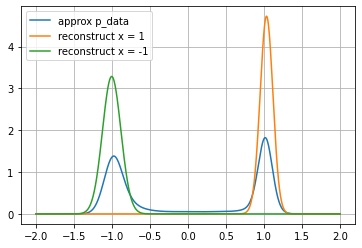

In [16]:
x_grid = np.linspace(-2.0, 2.0, num=1000)
p_z_given_x1 = vae.encode(torch.ones((1,)))
z1_samples = p_z_given_x1.sample((n_monte_carlo_samples,))
p_z_given_x_1 = vae.encode(-torch.ones((1,)))
z_1_samples = p_z_given_x_1.sample((n_monte_carlo_samples,))
z_samples = vae.sample_prior(n_monte_carlo_samples)

vae.eval()
with torch.no_grad():
    plt.figure()
    plot_pdf(x_grid, z_samples, vae.decode, "approx p_data")
    plot_pdf(x_grid, z1_samples, vae.decode, "reconstruct x = 1")
    plot_pdf(x_grid, z_1_samples, vae.decode, "reconstruct x = -1")
    plt.grid()
    plt.legend()
    plt.show()
    plt.close()

### Looking at the latent space
First, we look at the approximate prior distribution:
- $q_{\phi}(z) = \frac{1}{2} q_{\phi}(z | x = -1) + \frac{1}{2} + q_{\phi}(z| x = 1)$

Second, we look at the approximate posterior distributions:
- $q_{\phi}(z | x = -1)$
- $q_{\phi}(z | x = 1)$

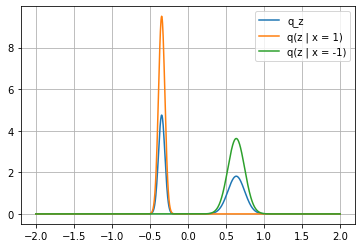

In [17]:
z_grid = np.linspace(-2, 2.0, num=1000)
vae.eval()
with torch.no_grad():
    plt.figure()
    plot_pdf(z_grid, torch.from_numpy(data).float(), vae.encode, "q_z")
    plot_pdf(z_grid, torch.ones((1, 1)), vae.encode, "q(z | x = 1)")
    plot_pdf(z_grid, -torch.ones((1, 1)), vae.encode, "q(z | x = -1)")
    plt.grid()
    plt.legend()
    plt.show()
    plt.close()